# Kernel Learning - SVR 

1. 최적화 문제 정의 

2. 라그랑주 승수법을 통해서 라그랑주 목적 함수로 변환 


3. 목적함수를 듀얼 함수로 변경하여 답 찾기 
> $L_D = \frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)x_i^Tx_j - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$ 
- Convex probelm solve package인 CVXPY를 통해서 $\alpha_i, \alpha_i^*$ 에 대한 해 찾기

4. 커널 트릭을 도입한다. 

--- 

**실제로 구현할 것**
1. 다양한 커널 함수에 따라 서로 다른 결과값이 나올 수 있도록 할 것. 
2. CVXPY 모듈을 통한 듀얼함수의 해 찾기 
3. 구한 $\alpha_i, \alpha_i^*$ 를 통해서 w, b, f(x)의 값 찾기 


**해결해야하는 점**
- 변수가 2개가 주어지는 상황에서의 Convex 문제의 해를 어떻게 찾을 것인가? 



(100,)


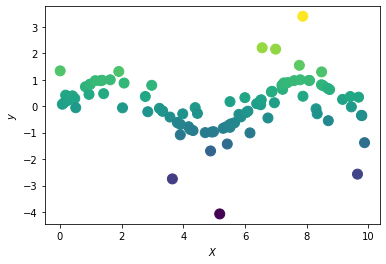

In [3]:
# 데이터 사용 및 라이브러리 설치 
! pip install cvxpy
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx


from sklearn.datasets import make_classification 

X = np.sort(10*np.random.rand(100,1),axis=0)
y = np.sin(X).ravel()
print(y.shape)
y[::5] += 5*(0.5-np.random.rand(20))
y[::3] += 2*(0.5-np.random.rand(34))


plt.scatter(X,y, marker = 'o', c=y, s = 100)
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.show()


### __init__ 함수 정의와 다양한 커널함수 적용하기 

**구현해야하는 것** 
1. 커널함수 
- Polynomial : $K(x_i,x_j) = (x_i*x_j)^d, c>0$ 
- Gaussian(RBF) : $K(x_i,x_j) = exp(-\frac{||x_i-x_j||^2}{2\sigma^2}, \sigma \neq 0$ 
- Sigmoid : $K(x_i,x_j) = tanh(a(x_i*x_j) + b), a,b >- 0 $

**필요한 것**
- xi, x_j 
- 커널함수를 지정하는 값 ("poly", "RBF", "sig") 

**함수의 형태**
- def __init__(self, X,y,c, kernel_type)

- def kernel_fn(self, x_i, x_j, kernel, coef, degree, gamma) : => 커널함수 값으로 반환 

- def kernel_matrix(self, X, kernel) : => ij 자리에 $ K(x_i, x_j)$ 값을 가진 n x n 행렬 반환   

In [22]:
class SVR() : 
    def __init__(self, X, y, c, epsilon, kernel_type) : 
        self.X = X
        self.n = np.shape(X)[0]
        self.m = np.shape(X)[1]
        
        self.y = y
        self.c = c
        self.epsilon = epsilon
        self.kernel_type = kernel_type
        self.k_matrix = self.kernel_matrix()
        
    def kernel_fn(self, x_i, x_j, kernel = None, coef = 1.0, degree = 3, gamma = 0.1) : 
        if kernel == "poly" : 
            return (np.dot(x_i, x_j) + coef)** degree 
        
        elif kernel == "RBF" : 
            return np.exp(- np.sum(np.square(x_i - x_j)) * gamma)
        
        elif kernel == "sig" : 
            return np.tanh(np.dot(x_i, x_j) + coef) 
        
        else : 
            return np.dot(x_i, x_j) 
        
    
    def kernel_matrix(self) : 
        k_matrix = np.zeros((self.n, self.n))
        for i in range(self.n) : 
            for j in range(self.n) : 
                k_matrix[i,j] = self.kernel_fn(self.X[i], self.X[j], self.kernel_type)
        return k_matrix
                

In [23]:
test = SVR(X,y, 3, 3, "")
print(test.kernel_matrix())

[[1.27945473e-05 2.64791823e-04 4.77625432e-04 ... 3.49777540e-02
  3.50186573e-02 3.53316438e-02]
 [2.64791823e-04 5.48004614e-03 9.88478185e-03 ... 7.23888312e-01
  7.24734834e-01 7.31212301e-01]
 [4.77625432e-04 9.88478185e-03 1.78299433e-02 ... 1.30573318e+00
  1.30726011e+00 1.31894402e+00]
 ...
 [3.49777540e-02 7.23888312e-01 1.30573318e+00 ... 9.56222402e+01
  9.57340617e+01 9.65897046e+01]
 [3.50186573e-02 7.24734834e-01 1.30726011e+00 ... 9.57340617e+01
  9.58460141e+01 9.67026575e+01]
 [3.53316438e-02 7.31212301e-01 1.31894402e+00 ... 9.65897046e+01
  9.67026575e+01 9.75669574e+01]]


### 2. CVXPY 모듈을 통한 듀얼함수의 해 찾기

**구현해야하는 것** 
1. CVX 모듈을 통해 max($L_D$)의 해 찾기 
- $L_D = \frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)x_i^Tx_j - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$ 


**필요한 것**
- obj : 최소/ 최대값을 찾고자 하는 함수 

> $\frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)K(x_i)^TK(x_j) - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$  

> let $\alpha_i^* - \alpha_i = t_i$. 

> obj : $ -\frac{1}{2}t * K * t.T + y * t.T -\epsilon * t.T + \epsilon * \alpha $

- const : 제약식 

> $\sum t = 0$

> $t_i \in [-C, C], \alpha_i \in [0, C]$

- problem = cvx.Problem(obj, const)
- result = prob.solve 



**함수의 형태**
- def __init__(self, X,y,c, kernel_type)

- def find_alpha(self) : => $\alpha^*, \alpha$ 값 반환 


In [40]:
#DCP 오류 발생. obj 가 convex 함수가 아니라고 함. 흠.. 어떻게 해결해야 하나

class SVR() : 
    def __init__(self, X, y, c, epsilon, kernel_type) : 
        self.X = X
        self.n = np.shape(X)[0]
        self.m = np.shape(X)[1]
        
        self.y = y
        self.c = c
        self.epsilon = epsilon
        self.kernel_type = kernel_type
        self.k_matrix = self.kernel_matrix()
        
    def kernel_fn(self, x_i, x_j, kernel = None, coef = 1.0, degree = 3, gamma = 0.1) : 
        if kernel == "poly" : 
            return (np.dot(x_i, x_j) + coef)** degree 
        
        elif kernel == "RBF" : 
            return np.exp(- np.sum(np.square(x_i - x_j)) * gamma)
        
        elif kernel == "sig" : 
            return np.tanh(np.dot(x_i, x_j) + coef) 
        
        else : 
            return np.dot(x_i, x_j) 
        
    
    def kernel_matrix(self) : 
        k_matrix = np.zeros((self.n, self.n))
        for i in range(self.n) : 
            for j in range(self.n) : 
                k_matrix[i,j] = self.kernel_fn(self.X[i], self.X[j], self.kernel_type)
        return k_matrix
                
    def find_alpha(self) : 
        t = cvx.Variable(self.n) # t = alpha_* - alpha
        alpha = cvx.Variable(self.n)

        """
        cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix()) 
             - self.epsilon*one_vec*(alpha+alpha_) 
             + self.y*(alpha-alpha_))
        """
        
        obj = cvx.Maximize(-0.5*cvx.quad_form(t, self.k_matrix) + self.epsilon*np.ones(self.n)*(-t + 2*alpha) + self.y*t) 
        const = [cvx.sum(t) == 0 ]
        for i in range(self.n) : 
            const += [t[i] >= -self.c, alpha[i] >=0]
            const += [t[i] <= self.c, alpha[i] <= self.c]
        svr = cvx.Problem(obj, const)
        svr.solve()
        
        t = np.array(t.value).flatten()
        alpha = np.array(alpha.value).flatten() 
        alpha_ = t + alpha
        
        return alpha_, alpha
        

In [56]:
test = SVR(X,y, 3, 3, "")
b = test.find_alpha()

print(np.shape(b))

C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var7322, [[1.27945473e-05 2.64791823e-04 4.77625432e-04 ... 3.49777540e-02
  3.50186573e-02 3.53316438e-02]
 [2.64791823e-04 5.48004614e-03 9.88478185e-03 ... 7.23888312e-01
  7.24734834e-01 7.31212301e-01]
 [4.77625432e-04 9.88478185e-03 1.78299433e-02 ... 1.30573318e+00
  1.30726011e+00 1.31894402e+00]
 ...
 [3.49777540e-02 7.23888312e-01 1.30573318e+00 ... 9.56222402e+01
  9.57340617e+01 9.65897046e+01]
 [3.50186573e-02 7.24734834e-01 1.30726011e+00 ... 9.57340617e+01
  9.58460141e+01 9.67026575e+01]
 [3.53316438e-02 7.31212301e-01 1.31894402e+00 ... 9.65897046e+01
  9.67026575e+01 9.75669574e+01]])

In [57]:
np.shape(b)

NameError: name 'b' is not defined